In [15]:
import requests
import json
import pandas as pd
import os
import re
import time
from tqdm import tqdm
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind
import itertools

# Premier League

In [11]:
# ---------- Config ----------
INPUT_DIR = "Premier_League_24_25_chapters"   # folder containing the CSVs
OUTPUT_FILE = os.path.join(INPUT_DIR, "Premier_League_24_25.csv")  # save inside same folder

# ---------- Collect all CSV paths ----------
csv_files = [
    os.path.join(INPUT_DIR, f)
    for f in sorted(os.listdir(INPUT_DIR))
    if f.endswith(".csv") and f != "Premier_League_24_25.csv"  # avoid merging itself
]

if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {INPUT_DIR}")

print(f"Found {len(csv_files)} CSV files in '{INPUT_DIR}'")

# ---------- Read and concatenate ----------
dfs = []
for path in tqdm(csv_files, desc="Merging CSV files", unit="file"):
    df = pd.read_csv(path)
    dfs.append(df)

merged_df = pd.concat(dfs, ignore_index=True)

# ---------- Keep only one row per (match_id, team_name) ----------
if {"match_id", "team_name"}.issubset(merged_df.columns):
    before = len(merged_df)
    merged_df = merged_df.drop_duplicates(subset=["match_id", "team_name"], keep="first")
    after = len(merged_df)
    print(f"\nRemoved {before - after:,} duplicate (match_id, team_name) entries.")
else:
    print("\n⚠️ Warning: columns 'match_id' and/or 'team_name' not found in the data!")

# ---------- Save to output ----------
merged_df.to_csv(OUTPUT_FILE, index=False, encoding="utf-8")

print(f"\n✅ Merged file saved as '{OUTPUT_FILE}' ({len(merged_df):,} unique match–team pairs total)")

Found 20 CSV files in 'Premier_League_24_25_chapters'


Merging CSV files: 100%|██████████| 20/20 [00:01<00:00, 13.04file/s]



Removed 401,032 duplicate (match_id, team_name) entries.

✅ Merged file saved as 'Premier_League_24_25_chapters\Premier_League_24_25.csv' (760 unique match–team pairs total)


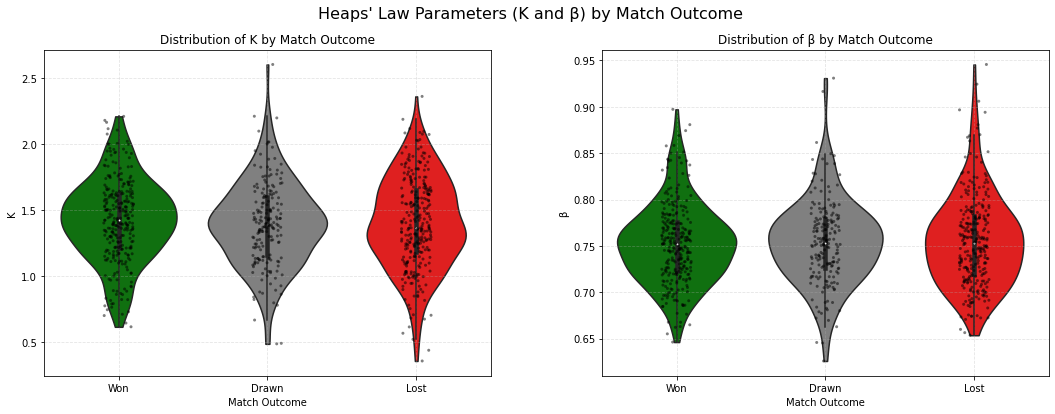

In [12]:
# ---------- Load dataset ----------
PATH = os.path.join("Premier_League_24_25_chapters", "Premier_League_24_25.csv")
df = pd.read_csv(PATH)

# ---------- Ensure proper data types ----------
df["K"] = pd.to_numeric(df["K"], errors="coerce")
df["beta"] = pd.to_numeric(df["beta"], errors="coerce")

# ---------- Filter valid rows ----------
df = df.dropna(subset=["K", "beta", "outcome"])

# ---------- Define outcome order ----------
outcome_order = ["Won", "Drawn", "Lost"]
df["outcome"] = pd.Categorical(df["outcome"], categories=outcome_order, ordered=True)

# ---------- Plot: 1 row, 2 columns ----------
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)
plt.subplots_adjust(wspace=0.25)

palette = {"Won": "green", "Drawn": "gray", "Lost": "red"}

# --- Left: K values ---
sns.violinplot(
    data=df, x="outcome", y="K", order=outcome_order,
    palette=palette, inner="box", cut=0, ax=axes[0]
)
sns.stripplot(
    data=df, x="outcome", y="K", order=outcome_order,
    color="black", alpha=0.5, size=3, ax=axes[0]
)
axes[0].set_title("Distribution of K by Match Outcome")
axes[0].set_xlabel("Match Outcome")
axes[0].set_ylabel("K")
axes[0].grid(True, linestyle="--", alpha=0.35)

# --- Right: β values ---
sns.violinplot(
    data=df, x="outcome", y="beta", order=outcome_order,
    palette=palette, inner="box", cut=0, ax=axes[1]
)
sns.stripplot(
    data=df, x="outcome", y="beta", order=outcome_order,
    color="black", alpha=0.5, size=3, ax=axes[1]
)
axes[1].set_title("Distribution of β by Match Outcome")
axes[1].set_xlabel("Match Outcome")
axes[1].set_ylabel("β")
axes[1].grid(True, linestyle="--", alpha=0.35)

plt.suptitle("Heaps' Law Parameters (K and β) by Match Outcome", fontsize=16)
plt.show()

In [17]:
# ---------- Load dataset ----------
PATH = os.path.join("Premier_League_24_25_chapters", "Premier_League_24_25.csv")
df = pd.read_csv(PATH)

# ---------- Clean data & filter only ‘Won’ and ‘Lost’ ----------
df = df.dropna(subset=["K", "beta", "outcome"])
df = df[df["outcome"].isin(["Won", "Lost"])]
df["outcome"] = df["outcome"].astype(str)

# ---------- Prepare groups ----------
group_won = df[df["outcome"] == "Won"]
group_lost = df[df["outcome"] == "Lost"]

# ---------- t-tests ----------
print("=== Independent two-sample t-tests (Won vs Lost) ===")

for var in ["K", "beta"]:
    x = group_won[var].dropna()
    y = group_lost[var].dropna()
    t_stat, p_value = ttest_ind(x, y, equal_var=False)  # Welch’s t-test (unequal variances)
    print(f"{var}: t = {t_stat:.3f}, p = {p_value:.5f}")
    if p_value < 0.05:
        print("→ Significant difference between Won vs Lost.")
    else:
        print("→ No significant difference between Won vs Lost.")
    print()

=== Independent two-sample t-tests (Won vs Lost) ===
K: t = 0.802, p = 0.42305
→ No significant difference between Won vs Lost.

beta: t = -0.661, p = 0.50895
→ No significant difference between Won vs Lost.



# Serie_A

In [18]:
# ---------- Config ----------
INPUT_DIR = "Serie_A_24_25_chapters"   # folder containing the CSVs
OUTPUT_FILE = os.path.join(INPUT_DIR, "Serie_A_24_25.csv")  # save inside same folder

# ---------- Collect all CSV paths ----------
csv_files = [
    os.path.join(INPUT_DIR, f)
    for f in sorted(os.listdir(INPUT_DIR))
    if f.endswith(".csv") and f != "Serie_A_24_25.csv"  # avoid merging itself
]

if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {INPUT_DIR}")

print(f"Found {len(csv_files)} CSV files in '{INPUT_DIR}'")

# ---------- Read and concatenate ----------
dfs = []
for path in tqdm(csv_files, desc="Merging CSV files", unit="file"):
    df = pd.read_csv(path)
    dfs.append(df)

merged_df = pd.concat(dfs, ignore_index=True)

# ---------- Keep only one row per (match_id, team_name) ----------
if {"match_id", "team_name"}.issubset(merged_df.columns):
    before = len(merged_df)
    merged_df = merged_df.drop_duplicates(subset=["match_id", "team_name"], keep="first")
    after = len(merged_df)
    print(f"\nRemoved {before - after:,} duplicate (match_id, team_name) entries.")
else:
    print("\n⚠️ Warning: columns 'match_id' and/or 'team_name' not found in the data!")

# ---------- Save to output ----------
merged_df.to_csv(OUTPUT_FILE, index=False, encoding="utf-8")

print(f"\n✅ Merged file saved as '{OUTPUT_FILE}' ({len(merged_df):,} unique match–team pairs total)")

Found 20 CSV files in 'Serie_A_24_25_chapters'


Merging CSV files: 100%|██████████| 20/20 [00:01<00:00, 11.83file/s]



Removed 365,053 duplicate (match_id, team_name) entries.

✅ Merged file saved as 'Serie_A_24_25_chapters\Serie_A_24_25.csv' (760 unique match–team pairs total)


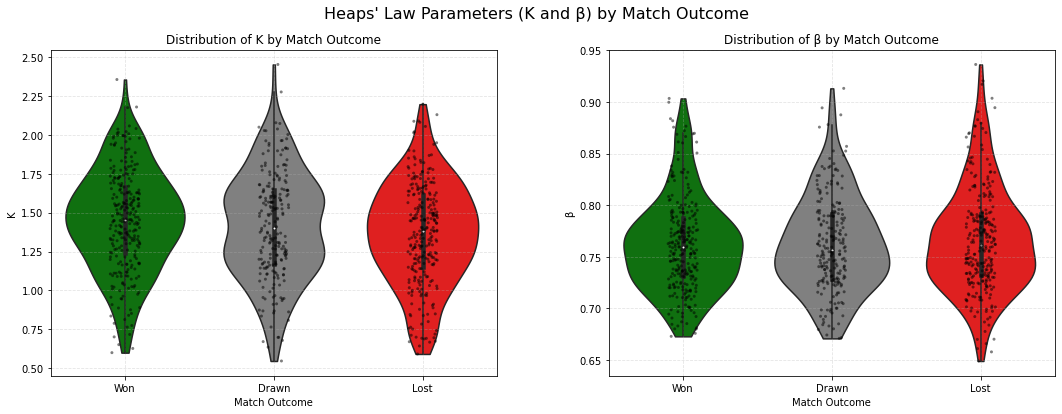

In [19]:
# ---------- Load dataset ----------
PATH = os.path.join("Serie_A_24_25_chapters", "Serie_A_24_25.csv")
df = pd.read_csv(PATH)

# ---------- Ensure proper data types ----------
df["K"] = pd.to_numeric(df["K"], errors="coerce")
df["beta"] = pd.to_numeric(df["beta"], errors="coerce")

# ---------- Filter valid rows ----------
df = df.dropna(subset=["K", "beta", "outcome"])

# ---------- Define outcome order ----------
outcome_order = ["Won", "Drawn", "Lost"]
df["outcome"] = pd.Categorical(df["outcome"], categories=outcome_order, ordered=True)

# ---------- Plot: 1 row, 2 columns ----------
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)
plt.subplots_adjust(wspace=0.25)

palette = {"Won": "green", "Drawn": "gray", "Lost": "red"}

# --- Left: K values ---
sns.violinplot(
    data=df, x="outcome", y="K", order=outcome_order,
    palette=palette, inner="box", cut=0, ax=axes[0]
)
sns.stripplot(
    data=df, x="outcome", y="K", order=outcome_order,
    color="black", alpha=0.5, size=3, ax=axes[0]
)
axes[0].set_title("Distribution of K by Match Outcome")
axes[0].set_xlabel("Match Outcome")
axes[0].set_ylabel("K")
axes[0].grid(True, linestyle="--", alpha=0.35)

# --- Right: β values ---
sns.violinplot(
    data=df, x="outcome", y="beta", order=outcome_order,
    palette=palette, inner="box", cut=0, ax=axes[1]
)
sns.stripplot(
    data=df, x="outcome", y="beta", order=outcome_order,
    color="black", alpha=0.5, size=3, ax=axes[1]
)
axes[1].set_title("Distribution of β by Match Outcome")
axes[1].set_xlabel("Match Outcome")
axes[1].set_ylabel("β")
axes[1].grid(True, linestyle="--", alpha=0.35)

plt.suptitle("Heaps' Law Parameters (K and β) by Match Outcome", fontsize=16)
plt.show()

In [20]:
# ---------- Load dataset ----------
PATH = os.path.join("Serie_A_24_25_chapters", "Serie_A_24_25.csv")
df = pd.read_csv(PATH)

# ---------- Clean data & filter only ‘Won’ and ‘Lost’ ----------
df = df.dropna(subset=["K", "beta", "outcome"])
df = df[df["outcome"].isin(["Won", "Lost"])]
df["outcome"] = df["outcome"].astype(str)

# ---------- Prepare groups ----------
group_won = df[df["outcome"] == "Won"]
group_lost = df[df["outcome"] == "Lost"]

# ---------- t-tests ----------
print("=== Independent two-sample t-tests (Won vs Lost) ===")

for var in ["K", "beta"]:
    x = group_won[var].dropna()
    y = group_lost[var].dropna()
    t_stat, p_value = ttest_ind(x, y, equal_var=False)  # Welch’s t-test (unequal variances)
    print(f"{var}: t = {t_stat:.3f}, p = {p_value:.5f}")
    if p_value < 0.05:
        print("→ Significant difference between Won vs Lost.")
    else:
        print("→ No significant difference between Won vs Lost.")
    print()

=== Independent two-sample t-tests (Won vs Lost) ===
K: t = 3.058, p = 0.00234
→ Significant difference between Won vs Lost.

beta: t = -1.138, p = 0.25557
→ No significant difference between Won vs Lost.



## La Liga

In [21]:
# ---------- Config ----------
INPUT_DIR = "La_Liga_24_25_chapters"   # folder containing the CSVs
OUTPUT_FILE = os.path.join(INPUT_DIR, "La_Liga_24_25.csv")  # save inside same folder

# ---------- Collect all CSV paths ----------
csv_files = [
    os.path.join(INPUT_DIR, f)
    for f in sorted(os.listdir(INPUT_DIR))
    if f.endswith(".csv") and f != "La_Liga_24_25.csv"  # avoid merging itself
]

if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {INPUT_DIR}")

print(f"Found {len(csv_files)} CSV files in '{INPUT_DIR}'")

# ---------- Read and concatenate ----------
dfs = []
for path in tqdm(csv_files, desc="Merging CSV files", unit="file"):
    df = pd.read_csv(path)
    dfs.append(df)

merged_df = pd.concat(dfs, ignore_index=True)

# ---------- Keep only one row per (match_id, team_name) ----------
if {"match_id", "team_name"}.issubset(merged_df.columns):
    before = len(merged_df)
    merged_df = merged_df.drop_duplicates(subset=["match_id", "team_name"], keep="first")
    after = len(merged_df)
    print(f"\nRemoved {before - after:,} duplicate (match_id, team_name) entries.")
else:
    print("\n⚠️ Warning: columns 'match_id' and/or 'team_name' not found in the data!")

# ---------- Save to output ----------
merged_df.to_csv(OUTPUT_FILE, index=False, encoding="utf-8")

print(f"\n✅ Merged file saved as '{OUTPUT_FILE}' ({len(merged_df):,} unique match–team pairs total)")

Found 20 CSV files in 'La_Liga_24_25_chapters'


Merging CSV files: 100%|██████████| 20/20 [00:02<00:00,  8.70file/s]



Removed 389,912 duplicate (match_id, team_name) entries.

✅ Merged file saved as 'La_Liga_24_25_chapters\La_Liga_24_25.csv' (760 unique match–team pairs total)


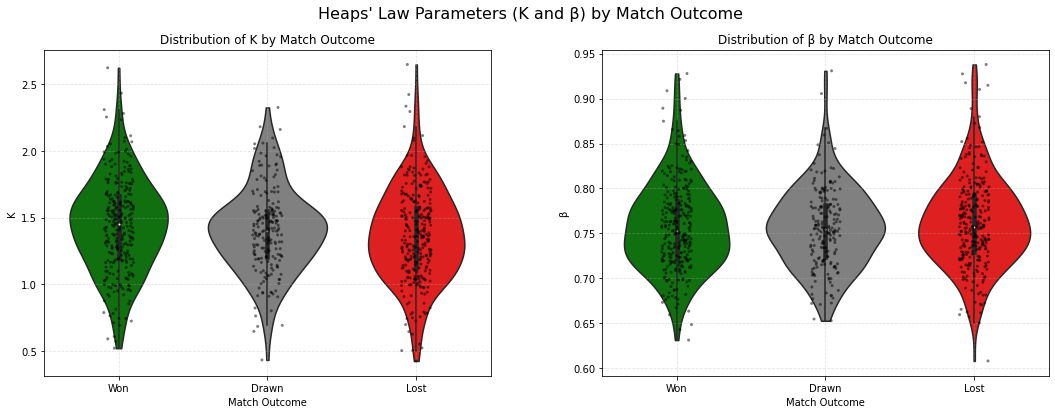

In [23]:
# ---------- Load dataset ----------
PATH = os.path.join("La_Liga_24_25_chapters", "La_Liga_24_25.csv")
df = pd.read_csv(PATH)

# ---------- Ensure proper data types ----------
df["K"] = pd.to_numeric(df["K"], errors="coerce")
df["beta"] = pd.to_numeric(df["beta"], errors="coerce")

# ---------- Filter valid rows ----------
df = df.dropna(subset=["K", "beta", "outcome"])

# ---------- Define outcome order ----------
outcome_order = ["Won", "Drawn", "Lost"]
df["outcome"] = pd.Categorical(df["outcome"], categories=outcome_order, ordered=True)

# ---------- Plot: 1 row, 2 columns ----------
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)
plt.subplots_adjust(wspace=0.25)

palette = {"Won": "green", "Drawn": "gray", "Lost": "red"}

# --- Left: K values ---
sns.violinplot(
    data=df, x="outcome", y="K", order=outcome_order,
    palette=palette, inner="box", cut=0, ax=axes[0]
)
sns.stripplot(
    data=df, x="outcome", y="K", order=outcome_order,
    color="black", alpha=0.5, size=3, ax=axes[0]
)
axes[0].set_title("Distribution of K by Match Outcome")
axes[0].set_xlabel("Match Outcome")
axes[0].set_ylabel("K")
axes[0].grid(True, linestyle="--", alpha=0.35)

# --- Right: β values ---
sns.violinplot(
    data=df, x="outcome", y="beta", order=outcome_order,
    palette=palette, inner="box", cut=0, ax=axes[1]
)
sns.stripplot(
    data=df, x="outcome", y="beta", order=outcome_order,
    color="black", alpha=0.5, size=3, ax=axes[1]
)
axes[1].set_title("Distribution of β by Match Outcome")
axes[1].set_xlabel("Match Outcome")
axes[1].set_ylabel("β")
axes[1].grid(True, linestyle="--", alpha=0.35)

plt.suptitle("Heaps' Law Parameters (K and β) by Match Outcome", fontsize=16)
plt.show()

In [24]:
# ---------- Load dataset ----------
PATH = os.path.join("La_Liga_24_25_chapters", "La_Liga_24_25.csv")
df = pd.read_csv(PATH)

# ---------- Clean data & filter only ‘Won’ and ‘Lost’ ----------
df = df.dropna(subset=["K", "beta", "outcome"])
df = df[df["outcome"].isin(["Won", "Lost"])]
df["outcome"] = df["outcome"].astype(str)

# ---------- Prepare groups ----------
group_won = df[df["outcome"] == "Won"]
group_lost = df[df["outcome"] == "Lost"]

# ---------- t-tests ----------
print("=== Independent two-sample t-tests (Won vs Lost) ===")

for var in ["K", "beta"]:
    x = group_won[var].dropna()
    y = group_lost[var].dropna()
    t_stat, p_value = ttest_ind(x, y, equal_var=False)  # Welch’s t-test (unequal variances)
    print(f"{var}: t = {t_stat:.3f}, p = {p_value:.5f}")
    if p_value < 0.05:
        print("→ Significant difference between Won vs Lost.")
    else:
        print("→ No significant difference between Won vs Lost.")
    print()

=== Independent two-sample t-tests (Won vs Lost) ===
K: t = 2.593, p = 0.00977
→ Significant difference between Won vs Lost.

beta: t = -1.038, p = 0.29974
→ No significant difference between Won vs Lost.



## Bundesliga

In [25]:
# ---------- Config ----------
INPUT_DIR = "Bundesliga_24_25_chapters"   # folder containing the CSVs
OUTPUT_FILE = os.path.join(INPUT_DIR, "Bundesliga_24_25.csv")  # save inside same folder

# ---------- Collect all CSV paths ----------
csv_files = [
    os.path.join(INPUT_DIR, f)
    for f in sorted(os.listdir(INPUT_DIR))
    if f.endswith(".csv") and f != "Bundesliga_24_25.csv"  # avoid merging itself
]

if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {INPUT_DIR}")

print(f"Found {len(csv_files)} CSV files in '{INPUT_DIR}'")

# ---------- Read and concatenate ----------
dfs = []
for path in tqdm(csv_files, desc="Merging CSV files", unit="file"):
    df = pd.read_csv(path)
    dfs.append(df)

merged_df = pd.concat(dfs, ignore_index=True)

# ---------- Keep only one row per (match_id, team_name) ----------
if {"match_id", "team_name"}.issubset(merged_df.columns):
    before = len(merged_df)
    merged_df = merged_df.drop_duplicates(subset=["match_id", "team_name"], keep="first")
    after = len(merged_df)
    print(f"\nRemoved {before - after:,} duplicate (match_id, team_name) entries.")
else:
    print("\n⚠️ Warning: columns 'match_id' and/or 'team_name' not found in the data!")

# ---------- Save to output ----------
merged_df.to_csv(OUTPUT_FILE, index=False, encoding="utf-8")

print(f"\n✅ Merged file saved as '{OUTPUT_FILE}' ({len(merged_df):,} unique match–team pairs total)")

Found 18 CSV files in 'Bundesliga_24_25_chapters'


Merging CSV files: 100%|██████████| 18/18 [00:01<00:00, 12.26file/s]



Removed 323,752 duplicate (match_id, team_name) entries.

✅ Merged file saved as 'Bundesliga_24_25_chapters\Bundesliga_24_25.csv' (612 unique match–team pairs total)


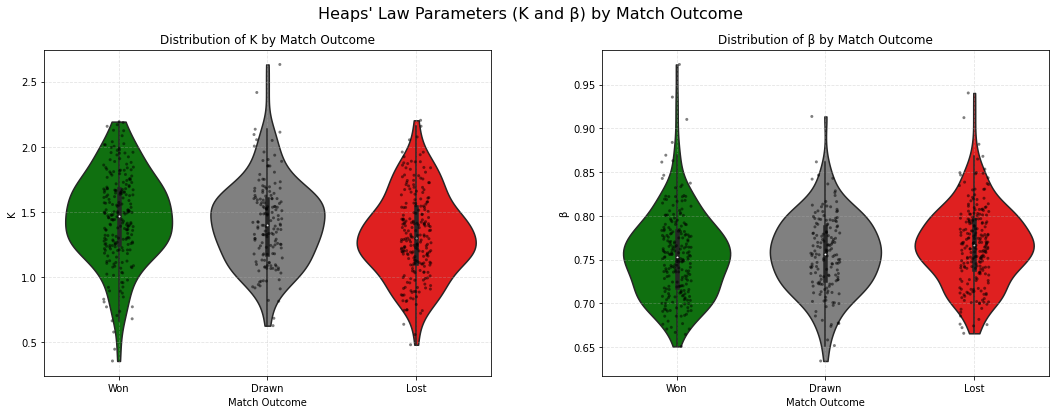

In [27]:
# ---------- Load dataset ----------
PATH = os.path.join("Bundesliga_24_25_chapters", "Bundesliga_24_25.csv")
df = pd.read_csv(PATH)

# ---------- Ensure proper data types ----------
df["K"] = pd.to_numeric(df["K"], errors="coerce")
df["beta"] = pd.to_numeric(df["beta"], errors="coerce")

# ---------- Filter valid rows ----------
df = df.dropna(subset=["K", "beta", "outcome"])

# ---------- Define outcome order ----------
outcome_order = ["Won", "Drawn", "Lost"]
df["outcome"] = pd.Categorical(df["outcome"], categories=outcome_order, ordered=True)

# ---------- Plot: 1 row, 2 columns ----------
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)
plt.subplots_adjust(wspace=0.25)

palette = {"Won": "green", "Drawn": "gray", "Lost": "red"}

# --- Left: K values ---
sns.violinplot(
    data=df, x="outcome", y="K", order=outcome_order,
    palette=palette, inner="box", cut=0, ax=axes[0]
)
sns.stripplot(
    data=df, x="outcome", y="K", order=outcome_order,
    color="black", alpha=0.5, size=3, ax=axes[0]
)
axes[0].set_title("Distribution of K by Match Outcome")
axes[0].set_xlabel("Match Outcome")
axes[0].set_ylabel("K")
axes[0].grid(True, linestyle="--", alpha=0.35)

# --- Right: β values ---
sns.violinplot(
    data=df, x="outcome", y="beta", order=outcome_order,
    palette=palette, inner="box", cut=0, ax=axes[1]
)
sns.stripplot(
    data=df, x="outcome", y="beta", order=outcome_order,
    color="black", alpha=0.5, size=3, ax=axes[1]
)
axes[1].set_title("Distribution of β by Match Outcome")
axes[1].set_xlabel("Match Outcome")
axes[1].set_ylabel("β")
axes[1].grid(True, linestyle="--", alpha=0.35)

plt.suptitle("Heaps' Law Parameters (K and β) by Match Outcome", fontsize=16)
plt.show()

In [29]:
# ---------- Load dataset ----------
PATH = os.path.join("Bundesliga_24_25_chapters", "Bundesliga_24_25.csv")
df = pd.read_csv(PATH)

# ---------- Clean data & filter only ‘Won’ and ‘Lost’ ----------
df = df.dropna(subset=["K", "beta", "outcome"])
df = df[df["outcome"].isin(["Won", "Lost"])]
df["outcome"] = df["outcome"].astype(str)

# ---------- Prepare groups ----------
group_won = df[df["outcome"] == "Won"]
group_lost = df[df["outcome"] == "Lost"]

# ---------- t-tests ----------
print("=== Independent two-sample t-tests (Won vs Lost) ===")

for var in ["K", "beta"]:
    x = group_won[var].dropna()
    y = group_lost[var].dropna()
    t_stat, p_value = ttest_ind(x, y, equal_var=False)  # Welch’s t-test (unequal variances)
    print(f"{var}: t = {t_stat:.3f}, p = {p_value:.5f}")
    if p_value < 0.05:
        print("→ Significant difference between Won vs Lost.")
    else:
        print("→ No significant difference between Won vs Lost.")
    print()

=== Independent two-sample t-tests (Won vs Lost) ===
K: t = 4.341, p = 0.00002
→ Significant difference between Won vs Lost.

beta: t = -2.714, p = 0.00690
→ Significant difference between Won vs Lost.

